In [1]:
import sys
import logging
import matplotlib.pyplot as plt
import cstrees.cstree as ct
import cstrees.scoring as sc
import cstrees.stage as st
import cstrees.learning as ctl
import networkx as nx
import numpy as np
%load_ext autoreload
%autoreload 2
#logging.basicConfig(stream=sys.stderr, level=logging.DEBUG)
logging.basicConfig(stream=sys.stderr, level=logging.ERROR)


In [2]:
from cstrees import csi_relation

ci = csi_relation.CI({1,2}, {3,4},{5})
print(ci)
dec = csi_relation.decomposition(ci)
for d in dec:
    print(d)

X1, X2 ⊥ X3, X4 | X5
X1 ⊥ X3 | X5
X1 ⊥ X4 | X5
X2 ⊥ X3 | X5
X2 ⊥ X4 | X5


In [3]:
wk = csi_relation.weak_union(ci)
for w in wk:
    print(w)

X1, X2 ⊥ X4 | X3, X5
X1, X2 ⊥ X3 | X4, X5
X2 ⊥ X3, X4 | X1, X5
X1 ⊥ X3, X4 | X2, X5


In [4]:
print("Original CI: ", ci)
pw = csi_relation.pairwise_cis(ci)
print("Pairwise CIs:")
for x in pw:
    print(x)

Original CI:  X1, X2 ⊥ X3, X4 | X5
Pairwise CIs:
X1 ⊥ X3 | X2, X4, X5
X1 ⊥ X4 | X2, X3, X5
X2 ⊥ X3 | X1, X4, X5
X2 ⊥ X4 | X1, X3, X5


In [5]:
c = csi_relation.Context({6:0})
csi = csi_relation.CSI(ci, c)

print("Original CSI: ", csi)
pw = csi_relation.pairwise_csis(csi)
print("Pairwise CSIs:")
for x in pw:
    print(x)

Original CSI:  X1, X2 ⊥ X3, X4 | X5, X6=0
Pairwise CSIs:
X1 ⊥ X3 | X2, X4, X5, X6=0
X1 ⊥ X4 | X2, X3, X5, X6=0
X2 ⊥ X3 | X1, X4, X5, X6=0
X2 ⊥ X4 | X1, X3, X5, X6=0


      a  b  c
0     2  2  2
1     1  0  1
2     1  0  0
3     1  0  0
4     0  0  0
...  .. .. ..
4996  1  0  0
4997  1  0  0
4998  0  0  0
4999  1  0  0
5000  1  0  0

[5001 rows x 3 columns]


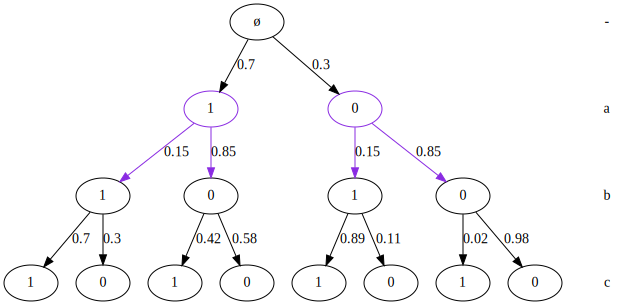

In [6]:
np.random.seed(6)
tree = ct.CStree([2] * 3, labels=["a", "b", "c"])

# V-structure
tree.update_stages({
    0: [st.Stage([{0, 1}])],
    1: [st.Stage([0, 0]), st.Stage([0, 1]), st.Stage([1, 0]), st.Stage([1, 1])]})

tree.sample_stage_parameters(alpha=1.0)

a = tree.plot()

# a.draw("testplot.png")
x = tree.sample(5000)
print(x)

true_cdags = tree.to_minimal_context_graphs()
for key, val in true_cdags.items():
    agraph = nx.nx_agraph.to_agraph(val)
    agraph.layout("dot")
    agraph.draw("testing/"+str(key) + "_true.png",
                args='-Glabel="'+str(key)+'"   ')
a


In [78]:

order = ["a", "b", "c"]
# Should order be expressed as the labels or as the levels?
# labels seems more natural but may include strings then which is a bit ugly.

# This is the order of the data columns.
s1 = sc.score_order(order, x, max_cvars=2, alpha_tot=1.0, method="BDeu", strategy="posterior")
print(s1)


score at level 0 : -3115.0216383111074
score at level 1 : -2123.2136719112837
score at level 2 : -2529.227777909125
-7767.463088131517


In [79]:
#order = [0, 2, 1]
order = ["a", "c", "b"]  # We know that b should not be to the very right.
s2 = sc.score_order(order, x, max_cvars=2, alpha_tot=1.0, method="BDeu", strategy="posterior")
print(s2)


score at level 0 : -3115.0216383111074
score at level 1 : -3032.6122823943247
score at level 2 : -1624.2134278714068
-7771.847348576838


optimal order: ['a', 'b', 'c'], score -7767.510194306091
stages :{0: [<cstrees.stage.Stage object at 0x7fb91566b130>], 1: [<cstrees.stage.Stage object at 0x7fb91566dd90>, <cstrees.stage.Stage object at 0x7fb91566dee0>, <cstrees.stage.Stage object at 0x7fb915673760>, <cstrees.stage.Stage object at 0x7fb915673190>], 2: [], -1: [<cstrees.stage.Stage object at 0x7fb912984550>]}

Optimal CStree stagings per level:
level 0:
[{0, 1}]
level 1:
[0, 0]
[1, 0]
[0, 1]
[1, 1]
level 2:


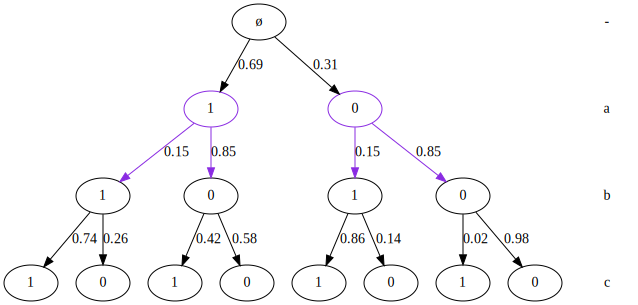

In [9]:
optord, score = ctl._find_optimal_order(
    x, strategy="posterior", max_cvars=2, alpha_tot=1.0, method="BDeu")
print("optimal order: {}, score {}".format(optord, score))

opttree = ctl._optimal_cstree_given_order(optord, x, max_cvars=2,
                             alpha_tot=1.0, method="BDeu")
print("stages :{}".format(opttree.stages))

print("\nOptimal CStree stagings per level:")
for key, val in opttree.stages.items():
    if key == -1:
        continue
    print("level {}:".format(key))
    for val2 in val:
        print(val2)
opttree.estimate_stage_parameters(x, alpha_tot=1.0, method="BDeu")
opttree.plot()


In [10]:
opt_cdags = opttree.to_minimal_context_graphs()
for key, val in opt_cdags.items():
    agraph = nx.nx_agraph.to_agraph(val)
    agraph.layout("dot")
    agraph.draw("testing/"+str(key) + "_opt.png",
                args='-Glabel="'+str(key)+'"   ')


In [11]:
tree = ctl.find_optimal_cstree(x, max_cvars=2, alpha_tot=1.0, method="BDeu")

tree.to_df()


,a,b,c
0,2,2,2
1,*,-,-
2,0,0,-
3,1,0,-
4,0,1,-
5,1,1,-


In [12]:
list(range(10,1,-1))

[10, 9, 8, 7, 6, 5, 4, 3, 2]

In [13]:
order = ["a", "b", "c"]
orderscore = sc.score_order(order, x, strategy="posterior", max_cvars=2, alpha_tot=1.0, method="BDeu")
nodescores = [sc._score_order_at_level(order, level, x, strategy="posterior", max_cvars=2, alpha_tot=1.0, method="BDeu") for level in range(len(order))]
print(orderscore)
print(nodescores)
print(np.sum(nodescores))
neig = ctl.get_relocation_neighborhood(order, 1, orderscore, nodescores, x, max_cvars=2, alpha_tot=1.0, method="BDeu")
print(order)
print("nodescores: ", nodescores)

print("neig: ", list(neig))


score at level 0 : -3113.9230260224394
score at level 1 : -2123.5013539837355
score at level 2 : -2531.307219450805
-7768.73159945698
[-3113.9230260224394, -2123.5013539837355, -2531.307219450805]
-7768.73159945698
['a', 'b', 'c']
nodescores:  [-3113.9230260224394, -2123.5013539837355, -2531.307219450805]
neig:  [0.4969012965502739, 0.4969012965502739, 0.006197406899578291]


In [25]:
orders, scores = ctl.gibbs_order_sampler(100, x, max_cvars=2, alpha_tot=1.0, method="BDeu")


initial order: ['a', 'b', 'c']
initial score: -7768.73159945698

iteration: 1
order: ['a', 'b', 'c']
moving node a
proposal probs: [0.49679444 0.49679444 0.00641111]
to new pos: 1
order: ['b', 'a', 'c']
score: -7768.73159945698

iteration: 2
order: ['b', 'a', 'c']
moving node c
proposal probs: [0.01258027 0.01258027 0.97483946]
to new pos: 2
order: ['b', 'a', 'c']
score: -7768.73159945698

iteration: 3
order: ['b', 'a', 'c']
moving node b
proposal probs: [0.4969013  0.4969013  0.00619741]
to new pos: 1
order: ['a', 'b', 'c']
score: -7768.73159945698

iteration: 4
order: ['a', 'b', 'c']
moving node b
proposal probs: [0.4969013  0.4969013  0.00619741]
to new pos: 1
order: ['a', 'b', 'c']
score: -7768.73159945698

iteration: 5
order: ['a', 'b', 'c']
moving node c
proposal probs: [0.01216857 0.01216857 0.97566285]
to new pos: 2
order: ['a', 'b', 'c']
score: -7768.73159945698

iteration: 6
order: ['a', 'b', 'c']
moving node c
proposal probs: [0.01216857 0.01216857 0.97566285]
to new pos: 2


KeyboardInterrupt: 

In [15]:
scores

[-7768.73159945698,
 -7768.73159945698,
 -7768.73159945698,
 -7768.73159945698,
 -7768.73159945698,
 -7768.73159945698,
 -7768.73159945698,
 -7768.73159945698,
 -7768.73159945698,
 -7768.73159945698,
 -7768.73159945698,
 -7768.73159945698,
 -7768.73159945698,
 -7768.73159945698,
 -7768.73159945698,
 -7768.73159945698,
 -7768.73159945698,
 -7768.73159945698,
 -7768.73159945698,
 -7768.73159945698,
 -7768.73159945698,
 -7768.73159945698,
 -7768.73159945698,
 -7768.73159945698,
 -7773.0817426848325,
 -7768.73159945698,
 -7768.73159945698,
 -7768.73159945698,
 -7768.73159945698,
 -7768.73159945698,
 -7768.73159945698,
 -7768.73159945698,
 -7768.73159945698,
 -7768.73159945698,
 -7768.73159945698,
 -7768.73159945698,
 -7768.73159945698,
 -7768.73159945698,
 -7768.73159945698,
 -7768.73159945698,
 -7768.73159945698,
 -7768.73159945698,
 -7768.73159945698,
 -7768.73159945698,
 -7768.73159945698,
 -7768.73159945698,
 -7768.73159945698,
 -7768.73159945698,
 -7768.73159945698,
 -7768.73159945698

In [16]:
orders

[['a', 'b', 'c'],
 ['a', 'b', 'c'],
 ['a', 'b', 'c'],
 ['a', 'b', 'c'],
 ['a', 'b', 'c'],
 ['a', 'b', 'c'],
 ['a', 'b', 'c'],
 ['a', 'b', 'c'],
 ['b', 'a', 'c'],
 ['b', 'a', 'c'],
 ['a', 'b', 'c'],
 ['b', 'a', 'c'],
 ['a', 'b', 'c'],
 ['a', 'b', 'c'],
 ['a', 'b', 'c'],
 ['b', 'a', 'c'],
 ['b', 'a', 'c'],
 ['b', 'a', 'c'],
 ['b', 'a', 'c'],
 ['b', 'a', 'c'],
 ['b', 'a', 'c'],
 ['b', 'a', 'c'],
 ['a', 'b', 'c'],
 ['a', 'b', 'c'],
 ['b', 'c', 'a'],
 ['b', 'a', 'c'],
 ['b', 'a', 'c'],
 ['b', 'a', 'c'],
 ['a', 'b', 'c'],
 ['a', 'b', 'c'],
 ['a', 'b', 'c'],
 ['a', 'b', 'c'],
 ['b', 'a', 'c'],
 ['b', 'a', 'c'],
 ['b', 'a', 'c'],
 ['b', 'a', 'c'],
 ['b', 'a', 'c'],
 ['a', 'b', 'c'],
 ['a', 'b', 'c'],
 ['b', 'a', 'c'],
 ['b', 'a', 'c'],
 ['b', 'a', 'c'],
 ['b', 'a', 'c'],
 ['b', 'a', 'c'],
 ['b', 'a', 'c'],
 ['b', 'a', 'c'],
 ['a', 'b', 'c'],
 ['a', 'b', 'c'],
 ['a', 'b', 'c'],
 ['b', 'a', 'c'],
 ['b', 'a', 'c'],
 ['a', 'b', 'c'],
 ['b', 'a', 'c'],
 ['b', 'a', 'c'],
 ['b', 'a', 'c'],
 ['a', 'b'

In [17]:
x

,a,b,c
0,2,2,2
1,1,0,1
2,1,0,0
3,1,0,0
4,0,0,0
...,...,...,...
4996,1,0,0
4997,1,0,0
4998,0,0,0
4999,1,0,0


In [26]:
scores = sc.score_tables(x)
scores

{'a': {'None': -3116.0517939666315,
  'b=0': -2650.871513156655,
  'b=1': -469.59637453270443,
  'c=0': -2160.734816627795,
  'c=1': -695.6685501567875,
  'b=0,c=0': -2057.2395269941417,
  'b=0,c=1': -141.82873783944257,
  'b=1,c=0': -85.49295540343263,
  'b=1,c=1': -380.1888463326886},
 'b': {'None': -2124.061484117625,
  'a=0': -662.125506390933,
  'a=1': -1466.4171921722918,
  'c=0': -661.3298339640329,
  'c=1': -1154.4252511459204,
  'a=0,c=0': -155.14647749767693,
  'a=0,c=1': -90.72916825778265,
  'a=1,c=0': -488.3787172705481,
  'a=1,c=1': -889.9590648722904},
 'c': {'None': -3293.330250844001,
  'a=0': -656.8442820067988,
  'a=1': -2376.827993423465,
  'b=0': -2580.760478296511,
  'b=1': -404.1887045852583,
  'a=0,b=0': -143.7640875067146,
  'a=0,b=1': -96.83168276196562,
  'a=1,b=0': -1985.1977559287652,
  'a=1,b=1': -303.4683689300532}}

In [80]:
oscores = sc.order_score_tables(x)

labels: ['a', 'b', 'c']
3

VARIABLE: a
level: -1
[]

going trough stages in staging at level -1
staging score: -3116.0517939666315
level: 0
['b']

going trough stages in staging at level 0
stage [{0, 1}]
context None score: -3116.0517939666315
staging score: -3116.0517939666315

going trough stages in staging at level 0
stage [0]
context b=0 score: -2650.871513156655
stage [1]
context b=1 score: -469.59637453270443
staging score: -3120.4678876893595
[-3116.0517939666315, -3120.4678876893595]
level: 0
['c']

going trough stages in staging at level 0
stage [{0, 1}]
context None score: -3116.0517939666315
staging score: -3116.0517939666315

going trough stages in staging at level 0
stage [0]
context c=0 score: -2160.734816627795
stage [1]
context c=1 score: -695.6685501567875
staging score: -2856.403366784583
[-3116.0517939666315, -2856.403366784583]
level: 1
['b', 'c']

going trough stages in staging at level 1
stage [{0, 1}]
context None score: -3116.0517939666315
stage [{0, 1}]
context

In [81]:
oscores

{'a': {'None': -3116.0517939666315,
  'b': -3116.0397850301542,
  'c': -2856.403366784583,
  'b,c': -2664.730313860978},
 'b': {'None': -2124.061484117625,
  'a': -2124.050228047842,
  'c': -1815.7550851099531,
  'a,c': -1624.213427879782},
 'c': {'None': -3293.330250844001,
  'a': -3033.672275430264,
  'b': -2984.949182881769,
  'a,b': -2529.2416289736657}}

In [82]:
sc.score_order_tables(["a", "b", "c"], oscores)

score: -3116.0517939666315
score: -2124.050228047842
score: -2529.2416289736657


-7769.343650988139

In [83]:
sc.score_order_tables(["a", "c", "b"], oscores)

score: -3116.0517939666315
score: -3033.672275430264
score: -1624.213427879782


-7773.937497276678